In [19]:
#!pip install optuna shap xgboost

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,PowerTransformer,OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression

import xgboost as xgb
import optuna
import shap
%matplotlib inline

In [28]:
path='/content/house_prices_train.csv'
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} not found")
    return pd.read_csv(path)


In [29]:
#showing numbers of missing values per column
def missing_values_summary(df):
    """Return DataFrame of columns with missing values and their counts."""
    missing = df.isna().sum()
    return missing[missing > 0].sort_values(ascending=False)

In [30]:
#filling missing values
def fill_missing_values(df):
    """Fill missing values according to business logic."""
    # Numeric fills
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['HasGarage'] = df['GarageYrBlt'].notna().astype(int)
    # Categorical fills
    fill_dict = {
        'Alley': 'None', 'FireplaceQu': 'None', 'PoolQC': 'None', 'GarageType': 'None',
        'BsmtQual': 'None', 'BsmtCond': 'None', 'BsmtExposure': 'None',
        'BsmtFinType1': 'None', 'BsmtFinType2': 'NoBasement', 'Electrical': 'None',
        'MasVnrType': 'None', 'GarageQual': 'None', 'GarageCond': 'None',
        'GarageFinish': 'None', 'Fence': 'None', 'MiscFeature': 'None'
    }
    df.fillna(value=fill_dict, inplace=True)
    return df

In [31]:
def predict_lotfrontage(df, predictors=['LotArea', 'YearBuilt']):
    """Impute missing 'LotFrontage' using regression per Neighborhood."""
    df = df.copy()
    for neighborhood in df['Neighborhood'].unique():
        neigh = df[df['Neighborhood'] == neighborhood]
        train = neigh[neigh['LotFrontage'].notnull()]
        test = neigh[neigh['LotFrontage'].isnull()]
        if not train.empty and not test.empty:
            features = [f for f in predictors if f in df.columns]
            train = train.dropna(subset=features)
            if not train.empty:
                X_train = train[features]
                y_train = train['LotFrontage']
                X_test = test[features].copy()
                for col in features:
                    X_test[col] = X_test[col].fillna(X_train[col].median())
                model = LinearRegression()
                model.fit(X_train, y_train)
                df.loc[test.index, 'LotFrontage'] = model.predict(X_test)
    return df


In [32]:
def ordinal_encode_qualities(df, cols):
    """Ordinal encode selected quality columns."""
    qual_order = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    categories = [qual_order] * len(cols)
    ordinal = OrdinalEncoder(categories=categories)
    df[cols] = ordinal.fit_transform(df[cols]).astype(int)
    return df

In [33]:
#performing feature engineering
def feature_eng(df):
    """Add basic engineered features."""
    df['HasBathroom'] = np.where((df['FullBath'] == 0) & (df['HalfBath'] == 0), 0, 1).astype('int64')
    year = 2025
    df['HouseAge'] = year - df['YearBuilt']
    df['YearsSinceRemod'] = year - df['YearRemodAdd']
    df['WasRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    return df

In [34]:
#plotting features using histplot
def feature_plot(df, features):
    for col in features:
        plt.figure(figsize=(8, 6))
        sns.histplot(x=df[col])
        plt.title(f"Histplot of {col} Skewness")
        plt.xlabel(f'{col}')
        plt.show()
    return df

In [35]:
#selectin features using SelectKBest
def select_features(df, features, target, k):
    X = df[features]
    y = df[target]
    selector = SelectKBest(f_regression, k=k)
    X_new = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    selected_features = [features[i] for i in selected_indices]
    return X_new, y, selected_features

In [36]:
def optuna_objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', .5, 1),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }
    model = xgb.XGBRegressor(**params, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    return -1.0 * scores.mean()

In [37]:
def train_and_evaluate(X_train, X_test, y_train, y_test, best_params):
    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse:.2f}')
    return model, y_pred, rmse

In [38]:
def plot_actual_vs_pred(y_true, y_pred, title='Actual vs. Predicted Sale Prices'):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', lw=2)
    plt.title(title)
    plt.xlabel('Actual Sale Price')
    plt.ylabel('Predicted Sale Price')
    plt.show()

In [47]:
def plot_shap_summary(model, X_train, X_test, feature_names):
    explainer = shap.Explainer(model.predict, X_train, feature_names=feature_names)
    #explainer = shap.KernelExplainer(model,shap.maskers.Independent(X_train), feature_names=feature_names)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    shap.plots.bar(shap_values)

Missing values before filling:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


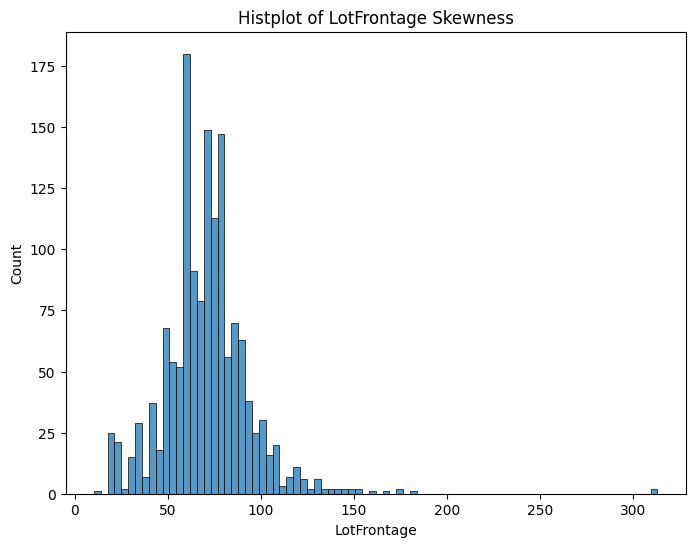

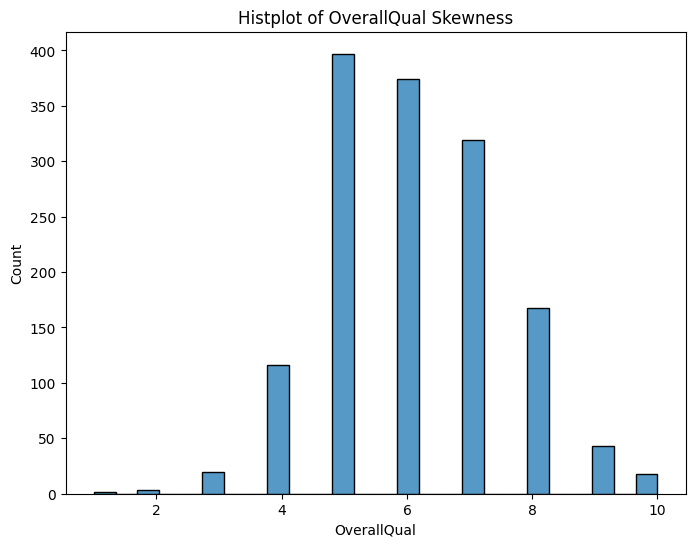

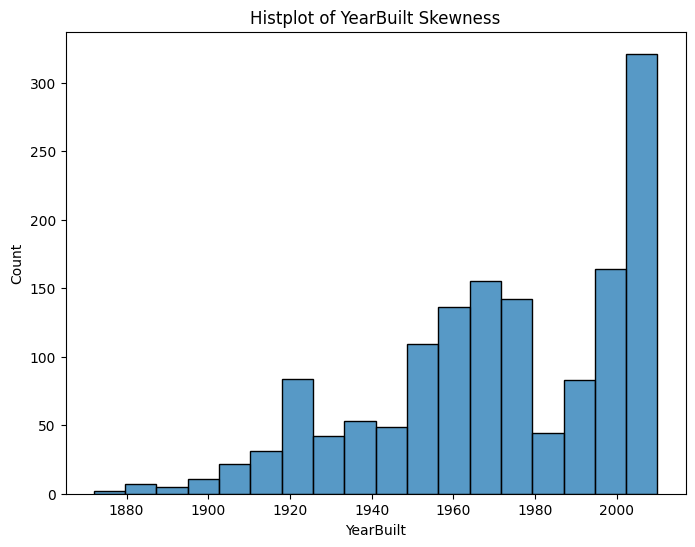

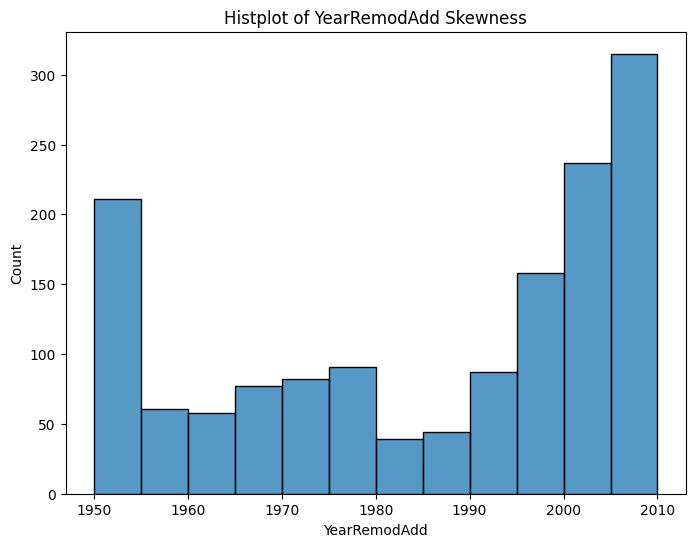

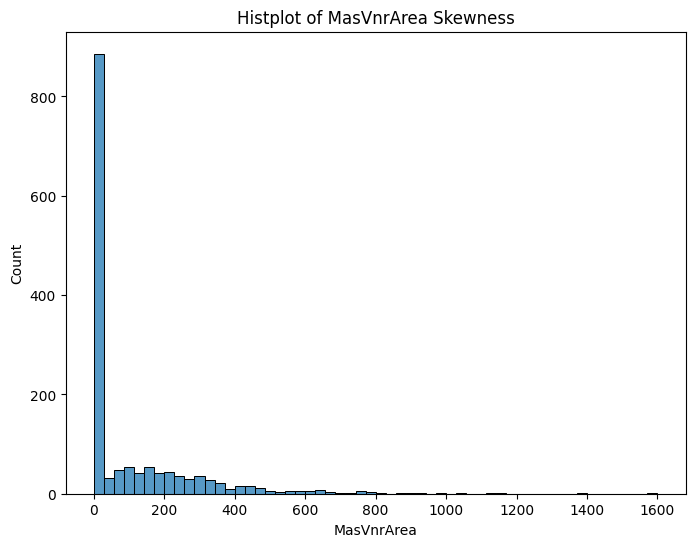

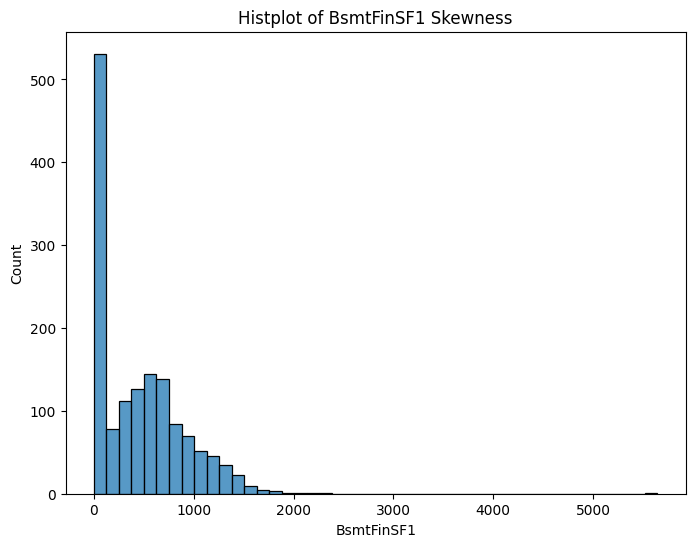

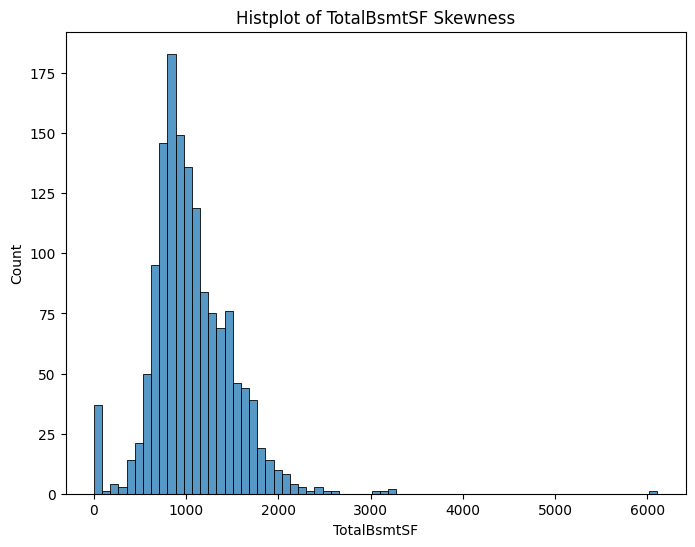

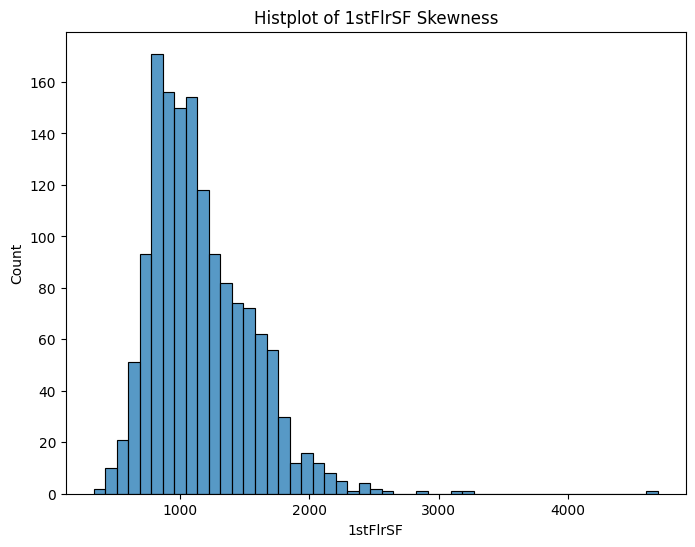

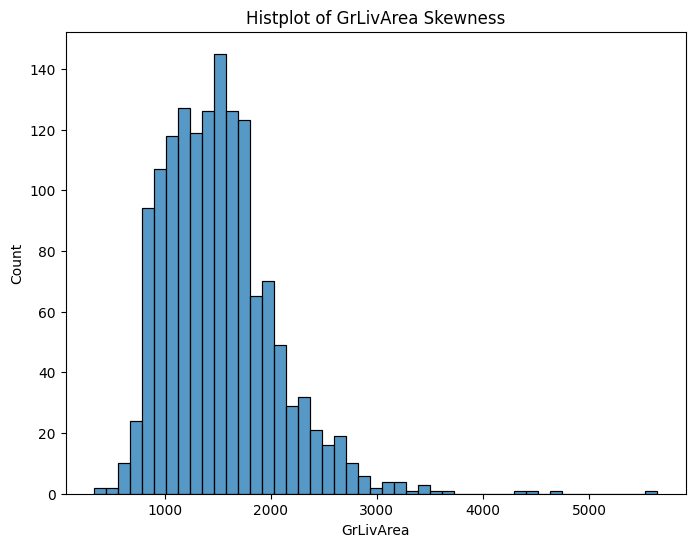

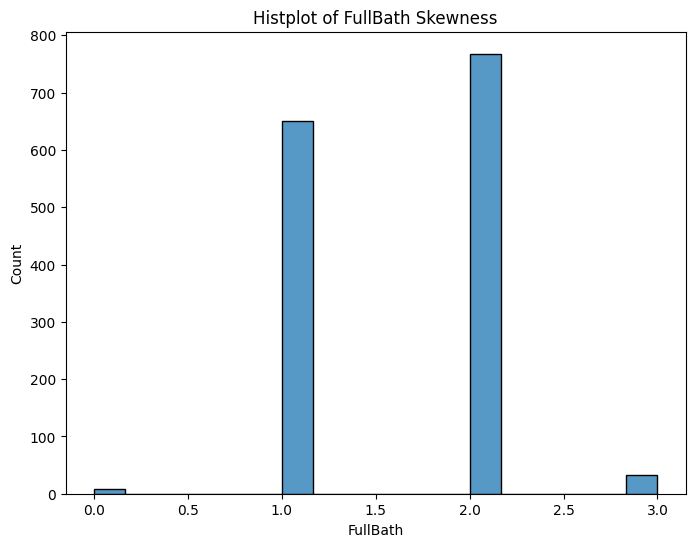

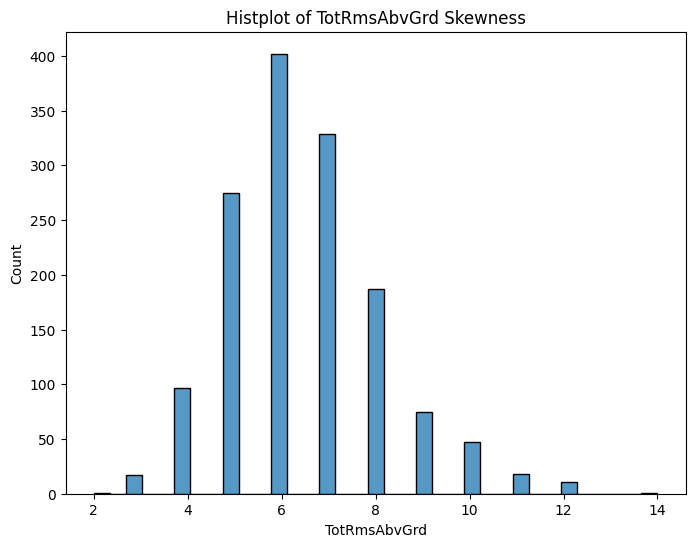

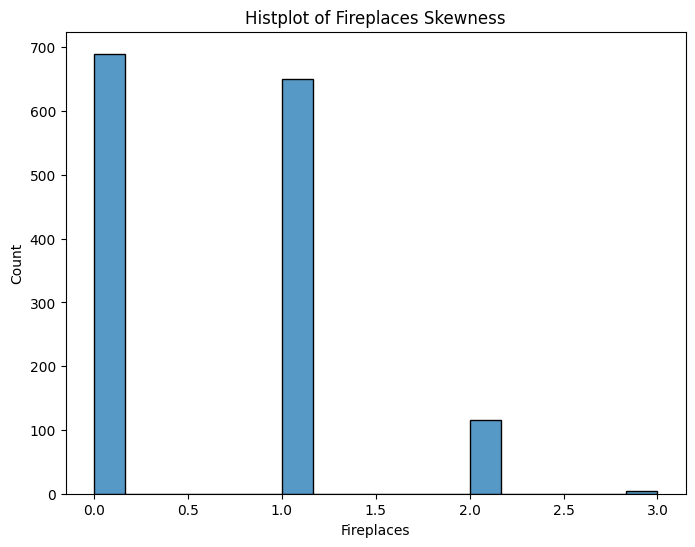

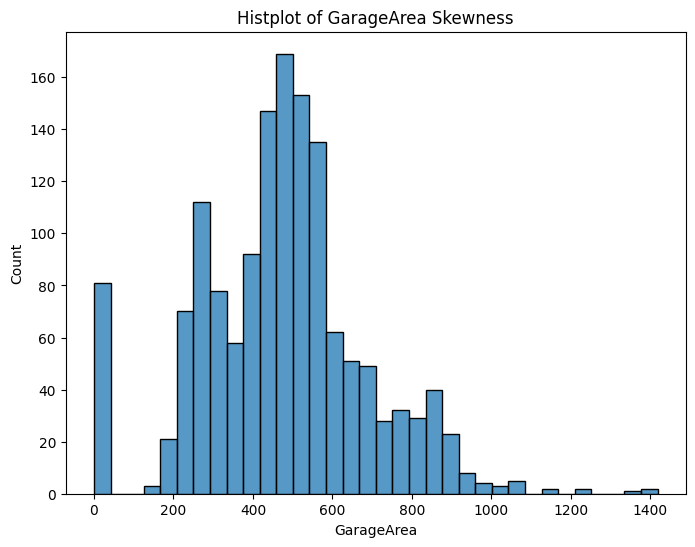

In [52]:
df=load_data(path)
model_features = [
'LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
'TotRmsAbvGrd', 'Fireplaces', 'GarageArea'
]

print("Missing values before filling:")
print(missing_values_summary(df))
df = fill_missing_values(df)

df = predict_lotfrontage(df, predictors=['LotArea', 'YearBuilt'])

ordinal_mappings_cols = [
'ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual',
'KitchenQual', 'GarageQual', 'FireplaceQu', 'GarageCond'
]
df = ordinal_encode_qualities(df, ordinal_mappings_cols)

df = feature_plot(df,model_features)

df['SalePrice_log'] = np.log1p(df['SalePrice'])

In [53]:
X, y, selected_features = select_features(df, model_features, 'SalePrice_log', k=13)
print("Selected features for modeling:", selected_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: optuna_objective(trial, X_train_sc, y_train), n_trials=20)
print(f'Best parameters: {study.best_params}')

model, y_pred_log, rmse_log = train_and_evaluate(X_train_sc, X_test_sc, y_train, y_test, study.best_params)

y_pred_o = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)
rmse_o = np.sqrt(mean_squared_error(y_test_original, y_pred_o))
print(f'RMSE (original scale): {rmse_o:.2f}')



[I 2025-10-23 08:15:33,688] A new study created in memory with name: no-name-56b20f6f-a47e-434e-84d4-6be3a00e605b


Selected features for modeling: ['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea']


[I 2025-10-23 08:15:34,336] Trial 0 finished with value: 0.03306203711686907 and parameters: {'n_estimators': 755, 'max_depth': 11, 'learning_rate': 0.11018496291203256, 'subsample': 0.7307368992448557, 'colsample_bytree': 0.7321400102629709, 'gamma': 2.3908599503918646}. Best is trial 0 with value: 0.03306203711686907.
[I 2025-10-23 08:15:35,119] Trial 1 finished with value: 0.030348566901833775 and parameters: {'n_estimators': 985, 'max_depth': 4, 'learning_rate': 0.07831082274993192, 'subsample': 0.9616933919912785, 'colsample_bytree': 0.6162903292831192, 'gamma': 1.6928821360219726}. Best is trial 1 with value: 0.030348566901833775.
[I 2025-10-23 08:15:35,380] Trial 2 finished with value: 0.038217228757667546 and parameters: {'n_estimators': 276, 'max_depth': 11, 'learning_rate': 0.18484947631189264, 'subsample': 0.9048685641976565, 'colsample_bytree': 0.8428107948904751, 'gamma': 3.7915562285254385}. Best is trial 1 with value: 0.030348566901833775.
[I 2025-10-23 08:15:35,935] Tri

Best parameters: {'n_estimators': 668, 'max_depth': 5, 'learning_rate': 0.11117930231441771, 'subsample': 0.5004681524981729, 'colsample_bytree': 0.6813037562470665, 'gamma': 0.05661067645561905}
RMSE: 0.15
RMSE (original scale): 27744.04


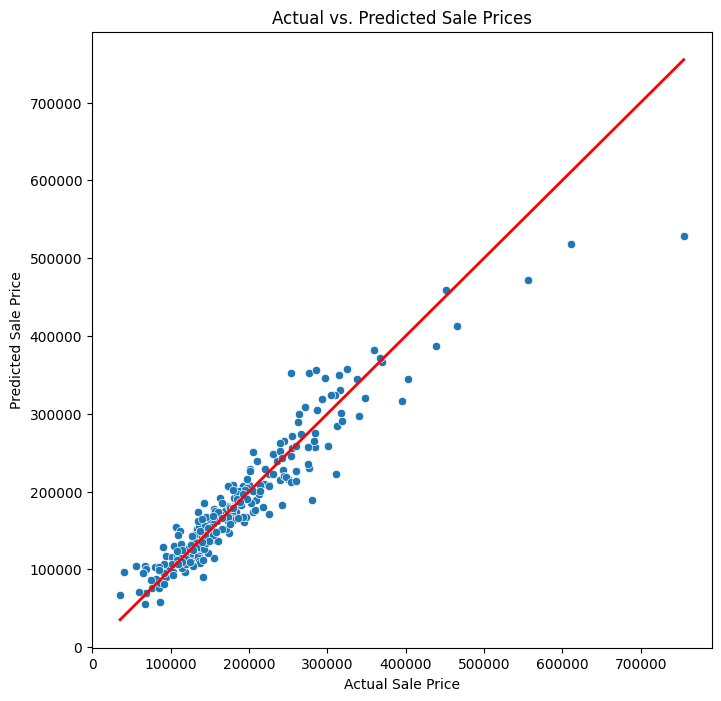

In [54]:
plot_actual_vs_pred(y_test_original, y_pred_o, title='Actual vs. Predicted Sale Prices')


PermutationExplainer explainer: 293it [00:54,  4.39it/s]
/tmp/ipython-input-2894690311.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names)


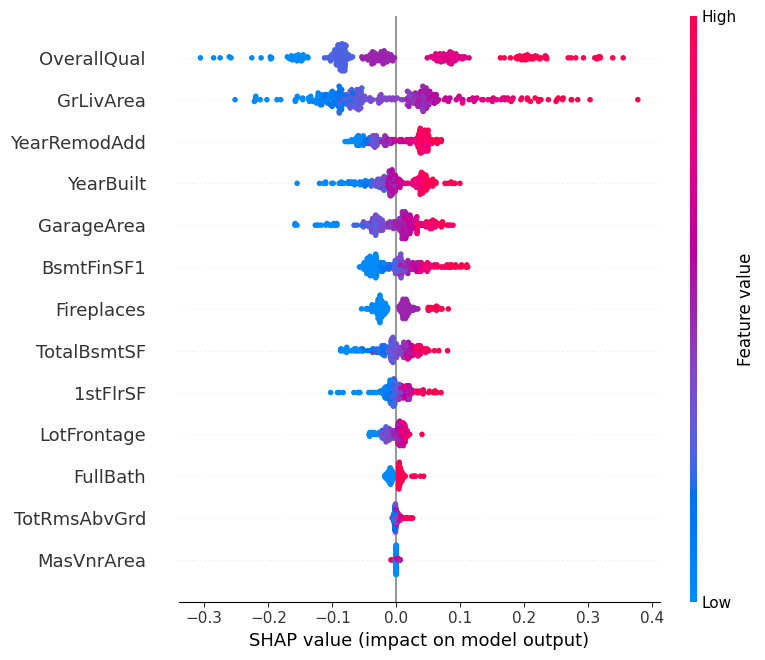

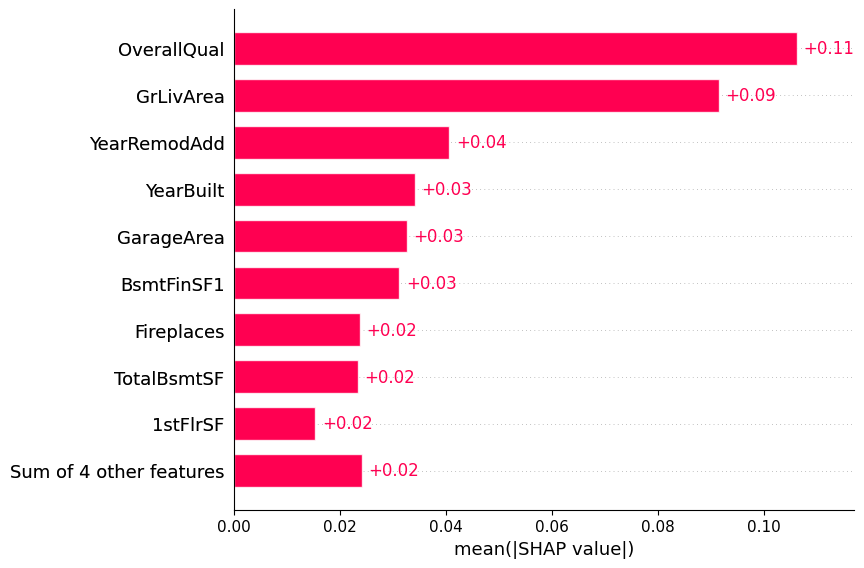

In [50]:
plot_shap_summary(model, X_train_sc, X_test_sc, selected_features)
